In [82]:
import sys
sys.path.append('../src/')


In [83]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans
from shapely.ops import cascaded_union
from shapely.geometry import MultiPolygon

In [84]:
%matplotlib inline

# Useful imports
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from constants import *
from utils.publication_functions import beautify_data_column_name
from sklearn.cluster import KMeans
from flows.specific.custom_flow import CustomFlow

# Data sources
from data_sources.specific.coca import Coca
from data_sources.specific.gold_stock_price import GoldStockPrice
from data_sources.specific.malaria_cases import Malaria
from data_sources.specific.mock_malaria_cases import MockMalaria
from data_sources.specific.temperature_average import TemperatureAverage
from data_sources.specific.temperature_max import TemperatureMax
from data_sources.specific.temperature_min import TemperatureMin
from data_sources.specific.temperature_average import TemperatureAverage
from data_sources.specific.precipitation_average import PrecipitationAverage
from data_sources.specific.precipitation_total import PrecipitationTotal
from data_sources.specific.deforestation_average import DeforestationAverage
from data_sources.specific.deforestation_total import DeforestationTotal
from data_sources.specific.fb_mobility import FBMobility

# Embedders
from embedders.specific.identity_embedder import IdentityEmbbeder
from embedders.specific.linear_regression_coefficient_embedder import LinearRegressionCoefficientEmbedder
from embedders.specific.mobility_to_distance_embedder import MobilityToDistanceEmbeder
from embedders.specific.mobility_to_similarity_embedder import MobilityToSimilarityEmbeder
from embedders.specific.aggregation_embedder import AggregationEmbedder

# Clusteres
from clusterers.specific.identity_clusterer import IdentityClusterer
from clusterers.specific.quantile_clusterer import QuantileClusterer
from clusterers.specific.sklearn_vector_clusterer import SklearnVectorClusterer
from clusterers.specific.two_tier_dbscan_clusterer import TwoTierDBSCANClusterer
from clusterers.specific.similarity_community_clusterer import SimilarityCommunityClusterer

# Geographies
from geography.specific.colombian_municipalities import ColombianMunicipalities
from geography.specific.colombia_grid import ColombianGrid
from geography.specific.colombia_rivers import ColombianRivers
from geography.general.geography_from_flow_output import GeographyFromFlowOutput
from geography.specific.colombia_indg_com import ColombianIndgCom
from geography.specific.colombia_indg_terr import ColombianIndgTerr

# Flows
from flows.specific.custom_flow import  CustomFlow

## Test flow

In [85]:
fuentes_incluidas = [DeforestationAverage]

In [86]:
flow = CustomFlow(ID = 'basic_analysis',
                    name = "Basic Analysis",
                    time_resolution = YEAR,
                    geography = ColombianGrid(),
                    vector_data_sources=fuentes_incluidas,
                    matrix_data_sources=[],
                    embedder=AggregationEmbedder(),
                    # clusterer=QuantileClusterer(ID="quantile", name="Quantile", quantiles=[0.2, 0.4, 0.6, 0.8] ,column_to_cluster="malaria_num_cases_sum")
                    clusterer=IdentityClusterer()
                    )

In [87]:
flow.run()

                  Starts Flow: Basic Analysis
                     Loads Initial Geography
                     Loads Data
                        Loads Vector Data
                        Found 1 elements
                           Extracts 1 of 1: Deforestation Average (deforestation_average) 
                        Done
                        
                        Loads Matrix Data
                        Found 0 elements
                        Done
                        ------------------
                     Embedds Data
                        Found 1 embedders
                           Aggregation Embedder
                     Clusters Data
                     Builds Final Geometry
                  Flow Ended
                  Done
                  -----------------


In [88]:
df_geo = flow.initial_geometry.merge(flow.df_vector)
df_geo.head()

,ID,left,top,right,bottom,geometry,date,deforestation_average_deforestation_average
0,10.0,-9098767.66,1.414865e+06,-9088767.66,1.404865e+06,"MULTIPOLYGON (((-81.68913 12.55114, -81.68899 ...",2001-12-31,0.0
1,10.0,-9098767.66,1.414865e+06,-9088767.66,1.404865e+06,"MULTIPOLYGON (((-81.68913 12.55114, -81.68899 ...",2002-12-31,0.0
2,10.0,-9098767.66,1.414865e+06,-9088767.66,1.404865e+06,"MULTIPOLYGON (((-81.68913 12.55114, -81.68899 ...",2003-12-31,0.0
3,10.0,-9098767.66,1.414865e+06,-9088767.66,1.404865e+06,"MULTIPOLYGON (((-81.68913 12.55114, -81.68899 ...",2004-12-31,0.0
4,10.0,-9098767.66,1.414865e+06,-9088767.66,1.404865e+06,"MULTIPOLYGON (((-81.68913 12.55114, -81.68899 ...",2005-12-31,0.0


,ID,geometry,date,deforestation_average_deforestation_average,year
80,6072.0,"POLYGON ((-79.00206 1.66112, -79.00154 1.66154...",2001-12-31,0.138504,2001
83,6072.0,"POLYGON ((-79.00206 1.66112, -79.00154 1.66154...",2004-12-31,0.051294,2004
84,6072.0,"POLYGON ((-79.00206 1.66112, -79.00154 1.66154...",2005-12-31,0.065007,2005
85,6072.0,"POLYGON ((-79.00206 1.66112, -79.00154 1.66154...",2006-12-31,0.095874,2006
87,6072.0,"POLYGON ((-79.00206 1.66112, -79.00154 1.66154...",2008-12-31,0.140505,2008


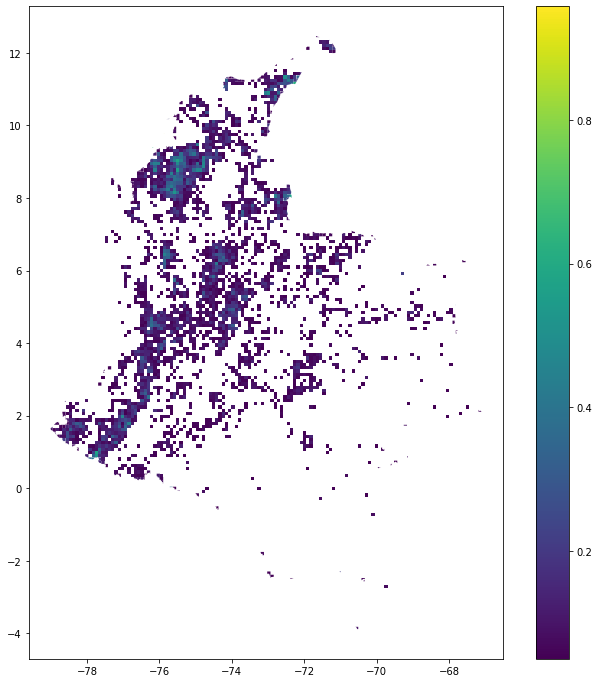

In [94]:
df_geo = flow.initial_geometry.merge(flow.df_vector)
column = 'deforestation_average_deforestation_average'

df_geo = df_geo[df_geo[column] > 0.05].copy()
df_geo.drop(columns=["left", "top", "right", "bottom"], inplace=True)
df_geo["year"] = df_geo.apply(lambda x: x.date.year, axis=1)
for d in df_geo["date"].unique():
    df_geo[df_geo.date == d].plot(figsize = (12,12), column = column, legend = True)
    break

df_geo.head()

In [76]:
df_geo["year"].unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019])

In [95]:
df_geo_quantiles = df_geo[column].quantile([0.2, 0.4, 0.6, 0.8])
def assign_quantile(x):
    if x <= df_geo_quantiles[0.2]:
        return "0.2"
    if x <= df_geo_quantiles[0.4]:
        return "0.4"
    if x <= df_geo_quantiles[0.6]:
        return "0.6"
    if x <= df_geo_quantiles[0.8]:
        return "0.8"
    else:
        return "1"

df_geo["quantile"] = df_geo.apply(lambda x: assign_quantile(x[column]), axis=1)
df_geo.head()


,ID,geometry,date,deforestation_average_deforestation_average,year,quantile
80,6072.0,"POLYGON ((-79.00206 1.66112, -79.00154 1.66154...",2001-12-31,0.138504,2001,1
83,6072.0,"POLYGON ((-79.00206 1.66112, -79.00154 1.66154...",2004-12-31,0.051294,2004,0.2
84,6072.0,"POLYGON ((-79.00206 1.66112, -79.00154 1.66154...",2005-12-31,0.065007,2005,0.4
85,6072.0,"POLYGON ((-79.00206 1.66112, -79.00154 1.66154...",2006-12-31,0.095874,2006,0.8
87,6072.0,"POLYGON ((-79.00206 1.66112, -79.00154 1.66154...",2008-12-31,0.140505,2008,1


In [96]:
path = "/Users/andreaparra/Dropbox/4_Work/GAIA/web-apps/mock-dashboard/src/data/deforestation.json"
df_geo.to_file(path, driver="GeoJSON", index=False)  

## IBD matrix data source

In [5]:
from constants import DATE, ID_2, GEOMETRY, ID, PIPELINE_DATA_FOLDER, RAW, ID_1, SUB_ID, USUAL_PROJECTION, isTimeResolutionValid
from data_sources.abstract.matrix_data_source import MatrixDataSource
from utils.date_functions import get_period_representative_function


# Constants
SOURCE_ID = "ibd"
NAME = "Identity by Descent"

In [24]:
class IBD(MatrixDataSource):
    '''
    Matrix Data Source
    '''

    def __init__(self):
        super().__init__()

        self.ibd_threshold = 0.9

    @property
    def ID(self):
        return SOURCE_ID

    @property
    def name(self):
        return NAME

    def set_ibd_threshold(self, ibd_threshold):
        self.ibd_threshold = ibd_threshold



    # Override
    def createData(self, df_geo, time_resolution):

        # Checks time resolution
        isTimeResolutionValid(time_resolution)

        # Data
        data_path = os.path.join(PIPELINE_DATA_FOLDER, RAW, 'ibd', 'ibd_muni.csv')
        muni_path = os.path.join(PIPELINE_DATA_FOLDER, RAW, 'geo', 'municipalities', 'municipalities.shp')

        df = pd.read_csv(data_path, parse_dates=["date_1", "date_2"], sep='\t')
        gdf_muni = gpd.read_file(muni_path)

        # Takes to end of period
        df["date_1"] = df["date_1"].apply(
            get_period_representative_function(time_resolution))

        df["date_2"] = df["date_2"].apply(
            get_period_representative_function(time_resolution))

        # Drop rows where time resolution doesn't match
        df = df[df["date_1"] == df["date_2"]]
        df.drop(columns=["date_2"], inplace=True)
        df.rename(columns={"date_1": "date"}, inplace=True)

        # Group by date id1, id2, and date to get min
        df = df.groupby(["date", "ID_1", "ID_2"]).min().reset_index()

        # Adds geometry
        # First ID_1
        gdf_ibd_1 = gpd.GeoDataFrame(gdf_muni.merge(df, left_on="muni_id", right_on=ID_1).dropna().drop(columns=["muni_id"]), 
                geometry='geometry', crs=USUAL_PROJECTION)
        gdf_ibd_1 = gpd.sjoin(gdf_ibd_1, df_geo[[ID, GEOMETRY]], how='left', predicate='contains')

        # Then ID_2
        gdf_ibd_2 = gpd.GeoDataFrame(gdf_muni.merge(df, left_on="muni_id", right_on=ID_2).dropna().drop(columns=["muni_id"]), 
                geometry='geometry', crs=USUAL_PROJECTION).dropna()                
        gdf_ibd_2 = gpd.sjoin(gdf_ibd_2, df_geo[[ID, GEOMETRY]], how='left', predicate='contains').drop(['index_right', ID], axis=1)

        # Merge gdf and merge geometries by union. Resulting geometry is the union of the corresponding polygons
        gdf_ibd = gdf_ibd_1[["geometry", "date", "ID_1", "ID_2"]].merge(gdf_ibd_2, on=["date", "ID_1", "ID_2"])        

        # Transform geomtry into a grouping
        gdf_ibd["geometry"] = gdf_ibd.apply(lambda x: gpd.GeoSeries([x["geometry_x"], x["geometry_y"]]).unary_union, axis=1)
        gdf_ibd.drop(columns=["geometry_x", "geometry_y"], inplace=True)
        
        gdf_ibd = gpd.GeoDataFrame(gdf_ibd, geometry='geometry')
        return gdf_ibd

    def createDataFromCachedSubGeography(self, time_resolution, sub_geography,
                                         df_map):
        # Checks time resolution
        isTimeResolutionValid(time_resolution)

        # Gets the data from the sub_geography
        df = self.get_data(sub_geography, time_resolution)

        # Maps the ids
        # id 1
        df.rename(columns={ID_1: SUB_ID}, inplace=True)
        df = df.merge(df_map).rename(columns={ID: ID_1})
        df.drop(SUB_ID, axis=1, inplace=True)
        # Id 2
        df.rename(columns={ID_2: SUB_ID}, inplace=True)
        df = df.merge(df_map).rename(columns={ID: ID_2})
        df.drop(SUB_ID, axis=1, inplace=True)

        # Agglomerates
        df_final = df.groupby([ID_1, ID_2, DATE]).sum().reset_index()

        return (df_final)

In [25]:
muni_path = os.path.join(PIPELINE_DATA_FOLDER, RAW, 'geo', 'municipalities', 'municipalities.shp')
gdf_muni = gpd.read_file(muni_path)
gdf_muni.rename(columns={"muni_id": "ID"}, inplace=True)

geography = ColombianMunicipalities()
time_resolution = MONTH

ds = IBD()
gdf_ds = ds.createData(gdf_muni, time_resolution)
gdf_ds.head()


/Users/andreaparra/Virtual-Envs/malaria_pl/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/andreaparra/Virtual-Envs/malaria_pl/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/andreaparra/Virtual-Envs/malaria_pl/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of part

,date,ID_1,ID_2,ibd,geometry
0,2020-01-31,76109,19318,0.04654,"MULTIPOLYGON (((-77.86901 2.27180, -77.86907 2..."
1,2020-01-31,76109,27001,0.26423,"MULTIPOLYGON (((-77.23164 4.16706, -77.22345 4..."
2,2020-02-29,76109,19318,0.11651,"MULTIPOLYGON (((-77.86901 2.27180, -77.86907 2..."
3,2020-02-29,76109,76109,0.99849,"POLYGON ((-77.23164 4.16706, -77.22345 4.15799..."
4,2020-03-31,76109,19318,0.30528,"MULTIPOLYGON (((-77.86901 2.27180, -77.86907 2..."


In [104]:

MultiPolygon([])
